In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [2]:
# Load CSV files
agg_df = pd.read_csv('pandas/agg_df.csv')
fish_df = pd.read_csv('pandas/fish_df.csv')

# <a id='toc2_'></a>[Agglomerative  Cluster Analysis](#toc0_)
## <a id='toc2_1_'></a>[Outliers](#toc0_)
We first do a hierarchical clustering to identify outliers in the data. We select a threshold distance to cut the dendrogram and identify clusters. Cluster size less than 2% of total samples are considered outliers.

To stay consistent with previous ecological analyses we will only use the Jaccard distance metric for clustering.

In [3]:
fish_df_binary = (fish_df > 0).astype(np.int8)
fish_df_binary.head()

,CNCF,WLYE,RVCS,YWPH,SMBF,STSN,RVRH,OSSF,PNSD,SFSN,...,SVRH,ERSN,LGPH,JYDR,GDRH,SHRH,BKCP,SGER,MMSN,RKBS
0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,1,1,0,1,0,1,0,0,0,0,...,1,1,1,0,1,1,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,1,1,...,1,0,0,1,1,0,1,0,0,0


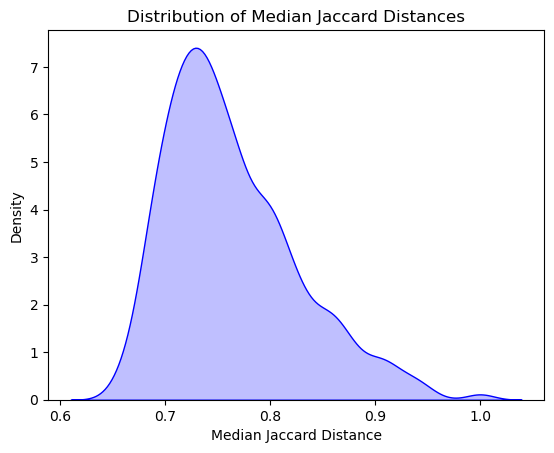

In [4]:
dist_matrix_jac = pdist(fish_df_binary, metric='jaccard') 
dist_df_jac = pd.DataFrame(squareform(dist_matrix_jac))

sns.kdeplot(dist_df_jac.median(axis=0), fill=True, color="blue")
plt.xlabel("Median Jaccard Distance")
plt.ylabel("Density")
plt.title("Distribution of Median Jaccard Distances")
plt.show()

# Clustering All samples

In [5]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score
from collections import Counter
from tqdm import tqdm

# --- helpers reused ---
def labels_at_threshold(Z, t, n):
    return fcluster(Z, t=t, criterion='distance')

def cluster_sizes_from_labels(labels):
    counts = Counter(labels)
    return np.array(list(counts.values()), dtype=int)

def variation_of_information(labels_a, labels_b):
    _, la = np.unique(labels_a, return_inverse=True)
    _, lb = np.unique(labels_b, return_inverse=True)
    n = len(la)
    joint_index = la * (lb.max() + 1) + lb
    joint = np.bincount(joint_index, minlength=(la.max()+1)*(lb.max()+1)).reshape(la.max()+1, lb.max()+1)
    Pab = joint / n
    Pa = Pab.sum(axis=1, keepdims=True)
    Pb = Pab.sum(axis=0, keepdims=True)

    def H(p):
        p = p[p > 0]
        return -np.sum(p * np.log(p))

    Ha = H(Pa.ravel())
    Hb = H(Pb.ravel())
    mask = Pab > 0
    MI = np.sum(Pab[mask] * (np.log(Pab[mask]) - np.log(Pa.repeat(Pb.shape[1], axis=1)[mask]) - np.log(Pb.repeat(Pa.shape[0], axis=0)[mask])))
    return (Ha + Hb) - 2 * MI

def threshold_grid_from_linkage(Z_full, n_thresholds=50, t_low=None, t_high=None, q_low=0.05, q_high=0.95):
    heights = Z_full[:, 2]
    if (t_low is not None) and (t_high is not None):
        lo = max(heights.min(), t_low)
        hi = min(heights.max(), t_high)
        thr = np.linspace(lo, hi, n_thresholds)
    else:
        qs = np.linspace(q_low, q_high, n_thresholds)
        thr = np.quantile(heights, qs)
    thr = np.unique(np.clip(thr, heights.min(), heights.max()))
    return thr

def minmax_norm(vals_dict):
    keys = list(vals_dict.keys())
    vals = np.array([vals_dict[k] for k in keys], dtype=float)
    vmin, vmax = vals.min(), vals.max()
    if vmax == vmin:
        return {k: 0.0 for k in keys}
    norm = (vals - vmin) / (vmax - vmin)
    return {k: v for k, v in zip(keys, norm)}

# --- NEW: size shortfall ---
def size_shortfall(sizes, target):
    # Sum of how far small clusters fall below the target, normalized by target
    deficits = np.maximum(0, target - sizes)
    return float(deficits.sum()) / float(target)

def select_clustering_threshold(
    X_binary,
    n_boot=1000,
    sample_frac=0.8,
    n_thresholds=50,
    # size rules
    small_min=30,            # clusters < small_min are "small"
    big_max=1000,            # hard cap on max cluster size
    max_small_clusters=0,    # hard cap on number of small clusters (0 = none allowed)
    # scoring weights
    w_instability=1.0,       # instability (1 - ARI to full) across bootstraps
    w_volatility=0.5,        # VI between adjacent thresholds (full data)
    w_small_full=0.6,        # penalty weight for # of small clusters (full data)
    w_shortfall_full=0.6,    # penalty weight for size shortfall (full data)
    w_small_boot=0.4,        # penalty weight for mean # small clusters (boot)
    w_shortfall_boot=0.4,    # penalty weight for mean size shortfall (boot)
    # threshold range (absolute)
    t_low=0.6,
    t_high=0.9,
    random_state=42,
    show_progress=True
):
    """
    Returns: best_threshold, metrics_df, labels_at_best (full-data labels)
    """
    rng = np.random.default_rng(random_state)
    n = X_binary.shape[0]

    # 1) Full-data Jaccard distance and linkage
    D_full = pdist(X_binary.astype(bool), metric='jaccard')
    Z_full = linkage(D_full, method='average')

    # 2) Candidate thresholds restricted to [t_low, t_high]
    thresholds = threshold_grid_from_linkage(
        Z_full, n_thresholds=n_thresholds, t_low=t_low, t_high=t_high
    )

    # 3) Full-data partitions and size metrics
    full_labels_by_t = {}
    volatility = {}
    n_small_full = {}
    shortfall_full = {}
    max_size_full = {}

    for i, t in enumerate(thresholds):
        labels = labels_at_threshold(Z_full, t, n=n)
        full_labels_by_t[t] = labels
        sizes = cluster_sizes_from_labels(labels)
        n_small_full[t] = int(np.sum(sizes < small_min))
        shortfall_full[t] = size_shortfall(sizes, small_min)
        max_size_full[t] = int(sizes.max()) if sizes.size else 0

    # Volatility as VI to neighbors
    for i, t in enumerate(thresholds):
        if i == 0:
            vi = variation_of_information(full_labels_by_t[thresholds[i]], full_labels_by_t[thresholds[i+1]])
        elif i == len(thresholds) - 1:
            vi = variation_of_information(full_labels_by_t[thresholds[i]], full_labels_by_t[thresholds[i-1]])
        else:
            vi_prev = variation_of_information(full_labels_by_t[thresholds[i]], full_labels_by_t[thresholds[i-1]])
            vi_next = variation_of_information(full_labels_by_t[thresholds[i]], full_labels_by_t[thresholds[i+1]])
            vi = 0.5 * (vi_prev + vi_next)
        volatility[t] = vi

    # 4) Bootstrap instability and bootstrap size metrics
    instability_sum = {t: 0.0 for t in thresholds}
    n_small_boot_sum = {t: 0.0 for t in thresholds}
    shortfall_boot_sum = {t: 0.0 for t in thresholds}

    # --- NEW: accumulate ARI moments to get mean & sd ---
    ari_sum = {t: 0.0 for t in thresholds}        # NEW
    ari_sumsq = {t: 0.0 for t in thresholds}      # NEW

    small_min_boot = int(round(sample_frac * small_min))

    boot_iter = range(n_boot)
    if show_progress:
        boot_iter = tqdm(boot_iter, desc="Bootstraps", unit="rep")

    for _ in boot_iter:
        idx = rng.choice(n, size=int(np.floor(n * sample_frac)), replace=False)
        Xb = X_binary[idx, :]
        Db = pdist(Xb.astype(bool), metric='jaccard')
        Zb = linkage(Db, method='average')

        for t in thresholds:
            lb_sub = labels_at_threshold(Zb, t, n=len(idx))
            lf_full = full_labels_by_t[t][idx]
            ari = adjusted_rand_score(lf_full, lb_sub)

            # existing instability metric
            instability_sum[t] += (1.0 - ari)

            # NEW: accumulate ARI moments
            ari_sum[t]   += ari
            ari_sumsq[t] += ari * ari

            sizes_b = cluster_sizes_from_labels(lb_sub)
            n_small_boot_sum[t] += np.sum(sizes_b < small_min_boot)
            shortfall_boot_sum[t] += size_shortfall(sizes_b, small_min_boot)

    # Averages across bootstraps
    instability = {t: instability_sum[t] / n_boot for t in thresholds}
    n_small_boot_mean = {t: n_small_boot_sum[t] / n_boot for t in thresholds}
    shortfall_boot_mean = {t: shortfall_boot_sum[t] / n_boot for t in thresholds}

    # --- NEW: mean ARI, SD of ARI, and 95% CI for mean ARI (normal approx) ---
    mean_ari = {t: ari_sum[t] / n_boot for t in thresholds}
    var_ari  = {t: max(0.0, ari_sumsq[t] / n_boot - mean_ari[t]**2) for t in thresholds}
    sd_ari   = {t: np.sqrt(var_ari[t]) for t in thresholds}
    se_ari   = {t: sd_ari[t] / np.sqrt(n_boot) for t in thresholds}
    ci95_low = {t: mean_ari[t] - 1.96 * se_ari[t] for t in thresholds}
    ci95_high= {t: mean_ari[t] + 1.96 * se_ari[t] for t in thresholds}

    # 5) Normalization and scoring with hard constraints
    inst_norm = minmax_norm(instability)
    vol_norm  = minmax_norm(volatility)
    small_full_norm = minmax_norm(n_small_full)
    shortfall_full_norm = minmax_norm(shortfall_full)
    small_boot_norm = minmax_norm(n_small_boot_mean)
    shortfall_boot_norm = minmax_norm(shortfall_boot_mean)

    scores = {}
    for t in thresholds:
        # Hard constraints
        if max_size_full[t] > big_max:
            scores[t] = 1e12 + (max_size_full[t] - big_max)  # reject
            continue
        if n_small_full[t] > max_small_clusters:
            scores[t] = 1e9 + (n_small_full[t] - max_small_clusters)
            continue

        s = (
            w_instability * inst_norm[t]
            + w_volatility * vol_norm[t]
            + w_small_full * small_full_norm[t]
            + w_shortfall_full * shortfall_full_norm[t]
            + w_small_boot * small_boot_norm[t]
            + w_shortfall_boot * shortfall_boot_norm[t]
        )
        scores[t] = s

    best_t = min(scores, key=scores.get)
    best_labels = full_labels_by_t[best_t]

    metrics = pd.DataFrame({
        "threshold": thresholds,
        "instability_1_minus_ARI": [instability[t] for t in thresholds],
        "volatility_VI_neighbor": [volatility[t] for t in thresholds],
        "n_small_clusters_full": [n_small_full[t] for t in thresholds],
        "size_shortfall_full": [shortfall_full[t] for t in thresholds],
        "n_small_clusters_boot_mean": [n_small_boot_mean[t] for t in thresholds],
        "size_shortfall_boot_mean": [shortfall_boot_mean[t] for t in thresholds],
        "max_cluster_size_full": [max_size_full[t] for t in thresholds],
        # --- NEW: ARI summaries ---
        "mean_ARI_boot": [mean_ari[t] for t in thresholds],
        "sd_ARI_boot":   [sd_ari[t] for t in thresholds],
        "mean_ARI_CI95_low":  [ci95_low[t] for t in thresholds],
        "mean_ARI_CI95_high": [ci95_high[t] for t in thresholds],
        "score": [scores[t] for t in thresholds],
    }).sort_values("threshold").reset_index(drop=True)

    return best_t, metrics, best_labels

In [6]:
best_t, metrics, labels = select_clustering_threshold(
    X_binary=fish_df_binary.values,
    n_boot=1000,
    sample_frac=0.8,
    n_thresholds=100,
    small_min=30,
    big_max=1000,
    max_small_clusters=10,       # <- hard cap: no small clusters on full data
    w_instability=1.0,
    w_volatility=0.4,
    w_small_full=1.0,
    w_shortfall_full=1.0,
    w_small_boot=0.7,
    w_shortfall_boot=0.7,
    t_low=0.6,                
    t_high=0.9,
    random_state=123,
    show_progress=True
)
print("Best threshold:", best_t)


Bootstraps: 100%|██████████| 1000/1000 [02:42<00:00,  6.14rep/s]

Best threshold: 0.7181818181818181


In [7]:
row = metrics.loc[metrics["threshold"] == best_t].iloc[0]
print(f"Best threshold: {best_t:.4f}")
print(f"Mean ARI at best t: {row['mean_ARI_boot']:.4f} ± {row['sd_ARI_boot']:.4f} "
      f"(SD across {int(1e3)} bootstraps)")
print(f"95% CI for mean ARI (normal approx): "
      f"[{row['mean_ARI_CI95_low']:.4f}, {row['mean_ARI_CI95_high']:.4f}]")

Best threshold: 0.7182
Mean ARI at best t: 0.4412 ± 0.0506 (SD across 1000 bootstraps)
95% CI for mean ARI (normal approx): [0.4380, 0.4443]


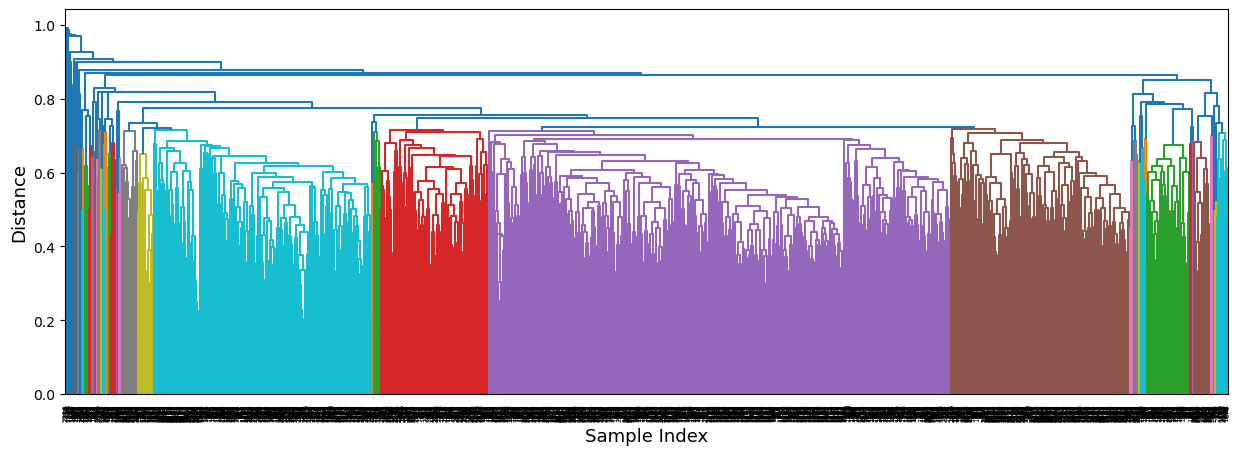


=== CLUSTER SUMMARY (threshold=0.7181818181818181) ===
Total clusters: 55
Clusters with >1000 samples: 0
Clusters with >30 samples: 8

Cluster sizes:
cluster
1     959
2     450
3     372
4     224
5      89
6      36
7      34
8      34
9      23
10     14
11     12
12     11
14      9
15      9
13      9
17      7
16      7
18      6
19      6
20      6
21      6
22      6
23      6
24      6
25      5
26      5
29      4
30      4
28      4
27      4
dtype: int64


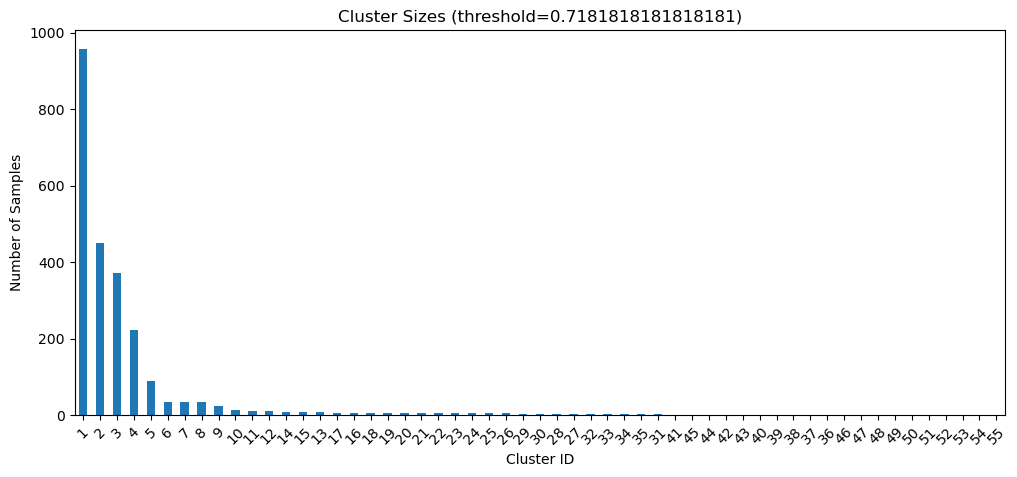

In [8]:
linked_jaccard = linkage(dist_matrix_jac, method='average')

cluster_threshold = best_t
plt.figure(figsize=(15, 5))
dendrogram(linked_jaccard, color_threshold=cluster_threshold) # you can change this value to change the number of clusters you get
plt.xlabel("Sample Index", fontsize=13)
plt.ylabel("Distance", fontsize=13)
plt.show()

# First assign clusters using fcluster
agg_df['cluster'] = fcluster(linked_jaccard, t=cluster_threshold, criterion='distance')
fish_df['cluster'] = agg_df['cluster']

# Then reassign cluster numbers in order by cluster size (largest = 1)
cluster_sizes = agg_df['cluster'].value_counts().sort_values(ascending=False)
cluster_map = {old: new for new, old in enumerate(cluster_sizes.index, 1)}
agg_df['cluster'] = agg_df['cluster'].map(cluster_map)
fish_df['cluster'] = agg_df['cluster']

# Summary of clusters
cluster_summary = agg_df.groupby('cluster').size().sort_values(ascending=False)
print(f"\n=== CLUSTER SUMMARY (threshold={cluster_threshold}) ===")
print(f"Total clusters: {len(cluster_summary)}")
print(f"Clusters with >1000 samples: {(cluster_summary >= 1000).sum()}")
print(f"Clusters with >30 samples: {(cluster_summary >= 30).sum()}")
print(f"\nCluster sizes:")
print(cluster_summary.head(30))

# Visualize cluster size distribution
plt.figure(figsize=(12, 5))
cluster_summary.plot(kind='bar')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Samples')
plt.title(f'Cluster Sizes (threshold={cluster_threshold})')
plt.xticks(rotation=45);
#print(agg_df.groupby('cluster').size())

In [9]:
# Save for 3cluster_visualization
agg_df.to_csv('pandas/agg_df_cluster1.csv', index=False)
fish_df.to_csv('pandas/fish_df_cluster1.csv', index=False)